<h2 align=center>Analyze Worldwide Box Office Data with Seaborn and Plotly</h2>
<img src="revenue.png">

In [1]:
import warnings
warnings.filterwarnings("ignore") 
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import eli5

Using TensorFlow backend.


### Data Loading and Exploration

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,Keywords,revenue,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,production_company_Regency Enterprises,production_company_BBC Films,production_company_Dune Entertainment,production_company_Working Title Films,production_company_Fox Searchlight Pictures,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films,num_countries,production_country_United States of America,production_country_United Kingdom,production_country_France,production_country_Germany,production_country_Canada,production_country_India,production_country_Italy,production_country_Japan,production_country_Australia,production_country_Russia,production_country_Spain,production_country_China,production_country_Hong Kong,production_country_Ireland,production_country_Belgium,production_country_South Korea,production_country_Mexico,production_country_Sweden,production_country_New Zealand,production_country_Netherlands,production_country_Czech Republic,production_country_Denmark,production_country_Brazil,production_country_Luxembourg,production_country_South Africa,num_languages,language_English,language_Français,language_Español,language_Deutsch,language_Pусский,language_Italiano,language_日本語,language_普通话,language_हिन्दी,language_,language_Português,language_العربية,language_한국어/조선말,language_广州话 / 廣州話,language_தமிழ்,language_Polski,language_Magyar,language_Latin,language_svenska,language_ภาษาไทย,language_Český,language_עִבְרִית,language_ελληνικά,language_Türkçe,language_Dansk,language_Nederlands,language_فارسی,language_Tiếng Việt,language_اردو,language_Română,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,genders_0_cast,genders_1_cast,genders_2_cast,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank,num_crew,crew_name_Avy Kaufman,crew_name_Robert Rodriguez,crew_name_Deborah Aquila,crew_name_James Newton Howard,crew_name_Mary Vernieu,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James Horner,crew_name_Kerry Barden,crew_name_Bob Weinstein,crew_name_Harvey Weinstein,crew_name_Janet Hirshenson,genders_0_crew,genders_1_crew,genders_2_crew,jobs_

In [4]:
train.shape, test.shape

((3000, 203), (4398, 202))

### Visualizing the Target Distribution


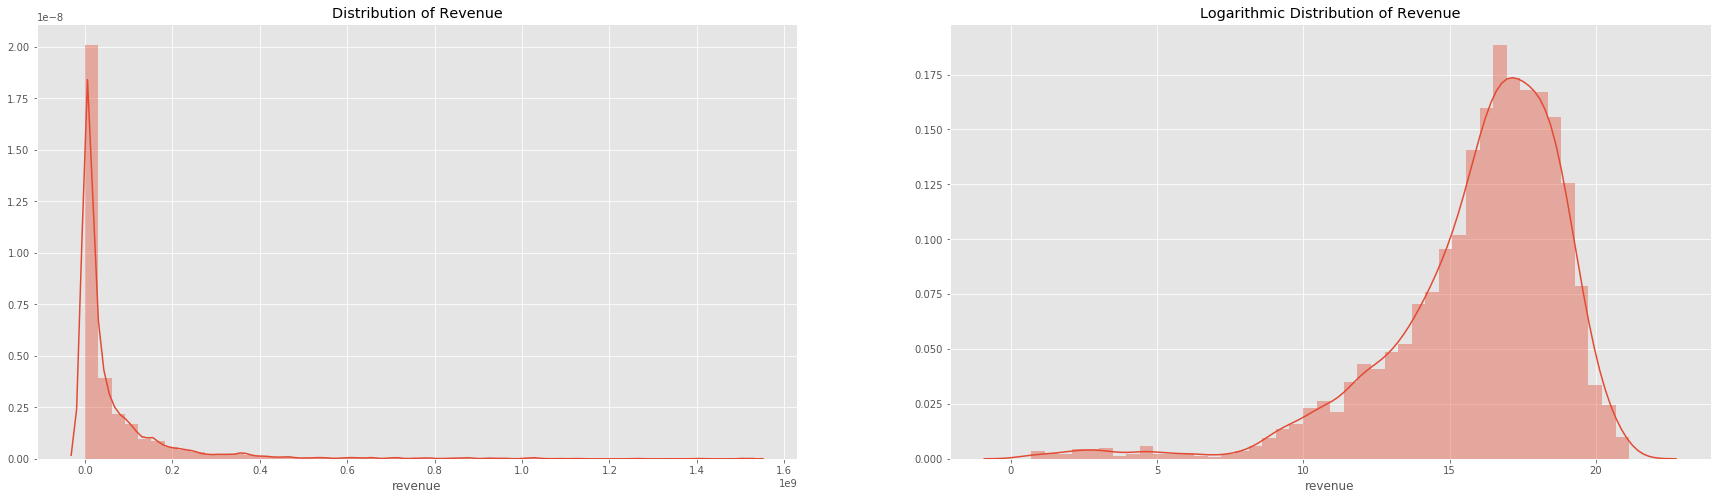

In [5]:
fig, ax = plt.subplots(figsize=(30,8))
plt.subplot(1, 2, 1)
sns.distplot(train.revenue, kde = True)  #train['revenue'] kde = kernel density estimate
plt.title('Distribution of Revenue'); #using ; to not get <matplotlib.axes.subplots.AxesSubplot at [*some memory location*]>
plt.subplot(1, 2, 2)
sns.distplot(np.log1p(train['revenue']), kde= True) #log1p because of 0 and Nan
plt.title('Logarithmic Distribution of Revenue');

In [6]:
train['log_revenue'] = np.log1p(train.revenue)

### Relationship between Film Revenue and Budget

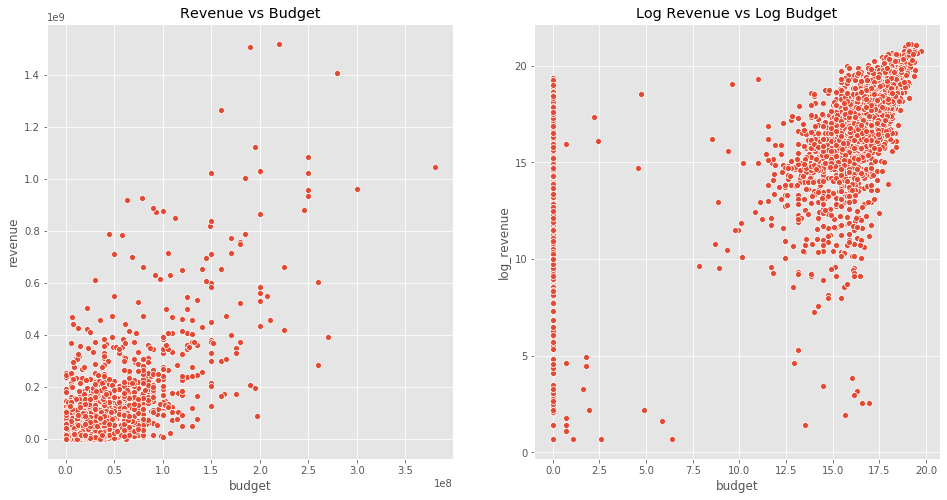

In [7]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.scatterplot(train['budget'], train.revenue)
plt.title('Revenue vs Budget');
plt.subplot(1,2,2)
sns.scatterplot(np.log1p(train['budget']), train.log_revenue)
plt.title('Log Revenue vs Log Budget');

In [8]:
train['log_budget'] = np.log1p(train.budget)
test['log_budget'] = np.log1p(test.budget)

### Does having an Official Homepage Affect Revenue?

In [9]:
train['homepage'].value_counts().head(10)

http://www.transformersmovie.com/                       4
http://www.thehobbit.com/                               2
http://www.lordoftherings.net/                          2
http://www.thebountyhunter-movie.net/                   1
http://www.mgm.com/#/our-titles/1970/The-Terminator/    1
http://marvel.com/movies/movie/13/elektra               1
http://theexpendables3film.com/                         1
http://www.lightsoutmovie.com/                          1
http://www.weinsteinco.com/#/film/idontknowhow          1
http://movies.disney.com/planes-fire-and-rescue         1
Name: homepage, dtype: int64

In [10]:
train['has_homepage'] = 0
train.loc[train.homepage.isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

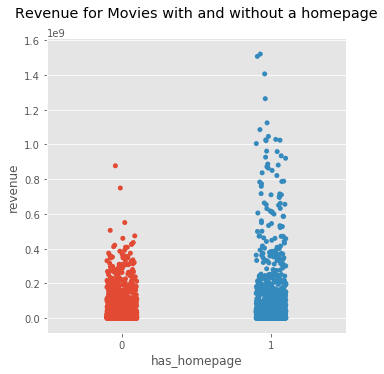

In [11]:
sns.catplot(x='has_homepage', y= 'revenue', data=train)  #homepage is a categorical column
plt.title('Revenue for Movies with and without a homepage\n');

### Distribution of Languages in Film

In [12]:
language_data = train.loc[train.original_language.isin(train['original_language'].value_counts().head(10).index)]

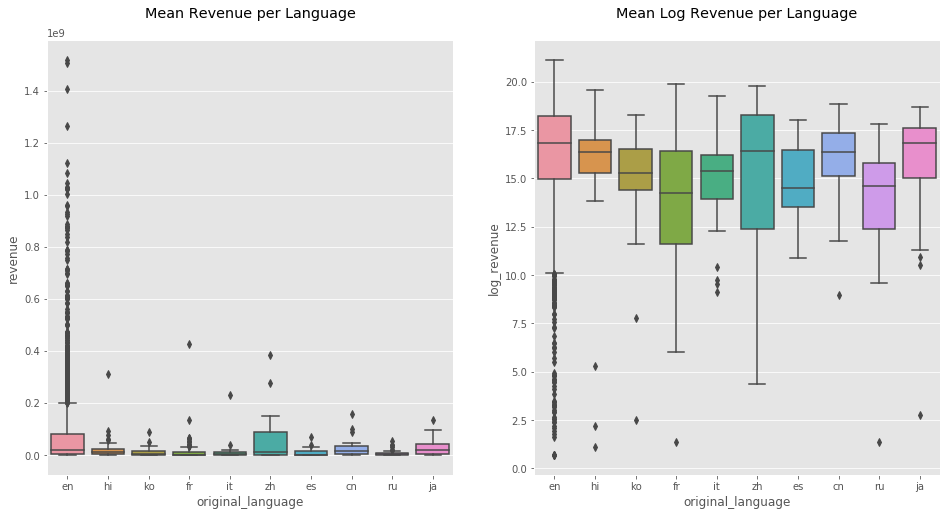

In [13]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.boxplot(x='original_language', y='revenue', data = language_data)
plt.title('Mean Revenue per Language\n');

plt.subplot(1,2,2)
sns.boxplot(x='original_language', y='log_revenue', data = language_data)
plt.title('Mean Log Revenue per Language\n');

### Frequent Words in Film Titles and Descriptions

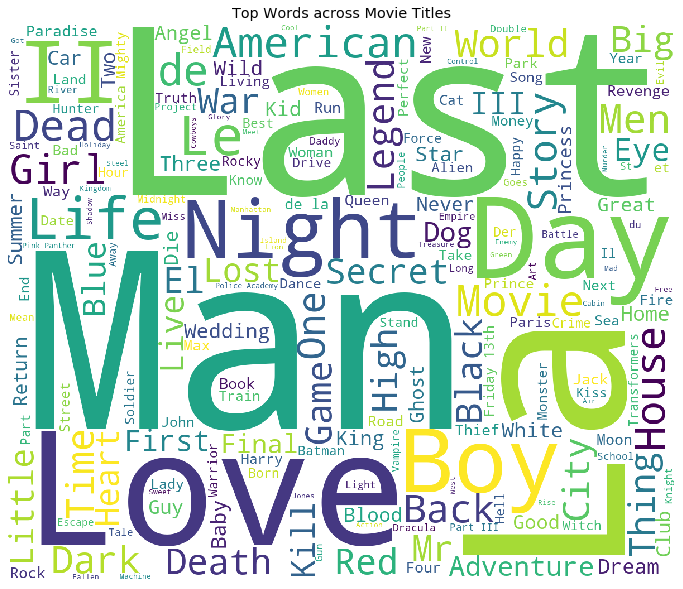

In [14]:
plt.figure(figsize=(12,12))
text = ' '.join(train.original_title.values)
wordcloud = WordCloud(max_font_size=None,
                     background_color='#fff',
                     width=1200,
                     height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top Words across Movie Titles')
plt.axis('off')
plt.show()

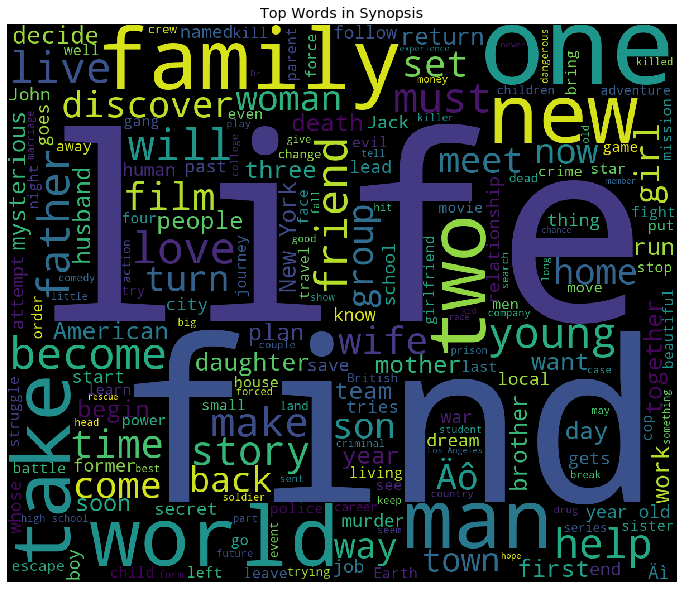

In [15]:
plt.figure(figsize=(12,12))
text = ' '.join(train.overview.fillna('').values)
wordcloud = WordCloud(max_font_size=None,
                     background_color='#000',
                     width=1200,
                     height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top Words in Synopsis')
plt.axis('off')
plt.show()

In [16]:
train['Keywords'].head(10)

0    [{'id': 4379, 'name': 'time travel'}, {'id': 9...
1    [{'id': 2505, 'name': 'coronation'}, {'id': 42...
2    [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...
3    [{'id': 10092, 'name': 'mystery'}, {'id': 1054...
4                                                   {}
5                                                   {}
6                                                   {}
7    [{'id': 917, 'name': 'journalism'}, {'id': 163...
8    [{'id': 2041, 'name': 'island'}, {'id': 4418, ...
9    [{'id': 11800, 'name': 'mockumentary'}, {'id':...
Name: Keywords, dtype: object

### Do Film Descriptions Impact Revenue?

In [17]:
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2),
    min_df=5
)
overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, train['log_revenue'])
eli5.show_weights(linreg, vec=vectorizer, top = 20, feature_filter=lambda x: x!= '<BIAS>')


In [18]:
print('Target value:', train['log_revenue'][1000])
eli5.show_prediction(linreg, doc=train['overview'].values[1000], vec=vectorizer)

Target value: 16.44583954907521


### Analyzing Movie Release Dates

In [19]:
test.loc[test['release_date'].isnull() == False, 'release_date'].head()

0    7/14/07
1    5/19/58
2    5/23/97
3     9/4/10
4    2/11/05
Name: release_date, dtype: object

### Preprocessing Features

In [20]:
def fix_date(x):
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

In [21]:
test.loc[test['release_date'].isnull() == True].head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,Keywords,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,production_company_Regency Enterprises,production_company_BBC Films,production_company_Dune Entertainment,production_company_Working Title Films,production_company_Fox Searchlight Pictures,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films,num_countries,production_country_United States of America,production_country_United Kingdom,production_country_France,production_country_Germany,production_country_Canada,production_country_India,production_country_Italy,production_country_Japan,production_country_Australia,production_country_Russia,production_country_Spain,production_country_China,production_country_Hong Kong,production_country_Ireland,production_country_Belgium,production_country_South Korea,production_country_Mexico,production_country_Sweden,production_country_New Zealand,production_country_Netherlands,production_country_Czech Republic,production_country_Denmark,production_country_Brazil,production_country_Luxembourg,production_country_South Africa,num_languages,language_English,language_Français,language_Español,language_Deutsch,language_Pусский,language_Italiano,language_日本語,language_普通话,language_हिन्दी,language_,language_Português,language_العربية,language_한국어/조선말,language_广州话 / 廣州話,language_தமிழ்,language_Polski,language_Magyar,language_Latin,language_svenska,language_ภาษาไทย,language_Český,language_עִבְרִית,language_ελληνικά,language_Türkçe,language_Dansk,language_Nederlands,language_فارسی,language_Tiếng Việt,language_اردو,language_Română,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,genders_0_cast,genders_1_cast,genders_2_cast,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank,num_crew,crew_name_Avy Kaufman,crew_name_Robert Rodriguez,crew_name_Deborah Aquila,crew_name_James Newton Howard,crew_name_Mary Vernieu,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James Horner,crew_name_Kerry Barden,crew_name_Bob Weinstein,crew_name_Harvey Weinstein,crew_name_Janet Hirshenson,genders_0_crew,genders_1_crew,genders_2_crew,jobs_Producer

In [22]:
test.loc[test['release_date'].isnull() == True, 'release_date'] = '05/01/00'

In [23]:
train['release_date'] = train['release_date'].apply(lambda x: fix_date(x))
test['release_date'] = test['release_date'].apply(lambda x: fix_date(x))

### Creating Features Based on Release Date

In [24]:
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

In [25]:
def process_date(df):
    date_parts = ['year', 'weekday', 'month', 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + '_' + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
    return df

train = process_date(train)
test = process_date(test)

### Using Plotly to Visualize the Number of Films Per Year

In [26]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = test['release_date_year'].value_counts().sort_index()

In [27]:
data = [go.Scatter(x = d1.index, y = d1.values, name = 'train'),
        go.Scatter(x = d2.index, y = d2.values, name = 'test')]

layout = go.Layout(dict(title = 'Number of Films per year',
                       xaxis = dict(title = 'Year'),
                       yaxis = dict(title = 'Count'),
                       ), legend = dict(orientation = 'v'))
iplot(dict(data=data, layout=layout))

### Number of Films and Revenue Per Year

In [28]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].sum()

data = [go.Scatter(x = d1.index, y = d1.values, name = 'Film Count'),
        go.Scatter(x = d2.index, y = d2.values, name = 'Total Revenue', yaxis = 'y2')]

layout = go.Layout(dict(title = 'Number of Films and Total Revenue per year',
                       xaxis = dict(title = 'Year'),
                       yaxis = dict(title = 'Count'),
                       yaxis2 = dict(title = 'Total Revenue', overlaying ='y', side='right')
                       ), legend = dict(orientation = 'v'))
iplot(dict(data=data, layout=layout))

In [29]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].mean()

data = [go.Scatter(x = d1.index, y = d1.values, name = 'Film Count'),
        go.Scatter(x = d2.index, y = d2.values, name = 'Mean Revenue', yaxis = 'y2')]

layout = go.Layout(dict(title = 'Number of Films and Mean Revenue per year',
                       xaxis = dict(title = 'Year'),
                       yaxis = dict(title = 'Count'),
                       yaxis2 = dict(title = 'Mean Revenue', overlaying ='y', side='right')
                       ), legend = dict(orientation = 'v'))
iplot(dict(data=data, layout=layout))

### Do Release Days Impact Revenue?

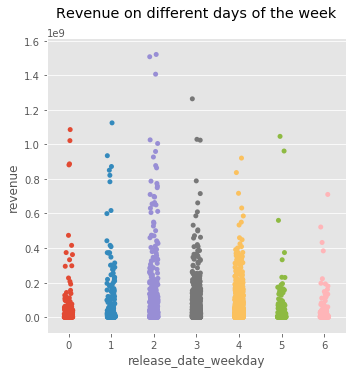

In [30]:
sns.catplot(x = 'release_date_weekday', y='revenue',data=train)
plt.title('Revenue on different days of the week\n');

### Relationship between Runtime and Revenue

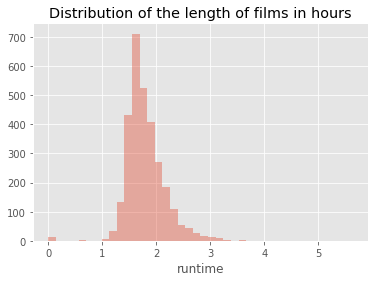

In [31]:
sns.distplot(train['runtime'].fillna(0) / 60, bins=40, kde = False)
plt.title('Distribution of the length of films in hours');

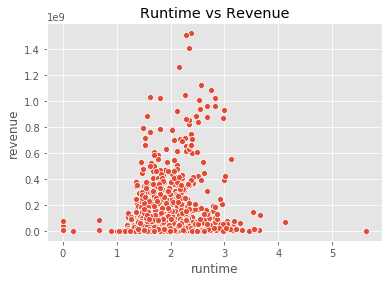

In [32]:
sns.scatterplot(train['runtime'].fillna(0) / 60, train['revenue'])
plt.title('Runtime vs Revenue');